# Sentiment Analysis

## 네이버 영화 리뷰 데이터

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Import Packages

In [2]:
import numpy as np
import keras 

# I. Naver Sentiment Movie Corpus v1.0

> ## 1) File Download

* Train : 150000
* Test : 50000

In [3]:
tr_url = 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt'
path_to_train_file = keras.utils.get_file('train.txt', tr_url)

te_url = 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt'
path_to_test_file = keras.utils.get_file('test.txt', te_url)

4898816/4893335 [==============================] - 0s 0us/step


> ## 2) 'X' Data

* 각 열은 Tab으로 구분
* '0'-부정, '1'-긍정

In [4]:
train_text = open(path_to_train_file, 'rb').read().decode(encoding = 'utf-8')
test_text = open(path_to_test_file, 'rb').read().decode(encoding = 'utf-8')

print('Length of text: {} characters'.format(len(train_text)))
print('Length of text: {} characters'.format(len(test_text)))
print()

print(train_text[:300])

Length of text: 6937271 characters
Length of text: 2318260 characters

id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의


> ## 3) 'y' Label

* 각 문장을 '\n'으로 분리 후 3열(index번호 2)의 값을 정수로 추출

In [5]:
train_Y = np.array([[int(row.split('\t')[2])] for row in train_text.split('\n')[1:] if row.count('\t') > 0])
test_Y = np.array([[int(row.split('\t')[2])] for row in test_text.split('\n')[1:] if row.count('\t') > 0])

print(train_Y.shape, test_Y.shape)
print(train_Y[:5])

(150000, 1) (50000, 1)
[[0]
 [1]
 [0]
 [0]
 [1]]


# II. Data Cleaning

> ## 1) 'X' Data Cleaning

https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py

In [6]:
import re

def clean_str(string):    
    string = re.sub(r"[^가-힣A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\'{2,}", "\'", string)
    string = re.sub(r"\'", "", string)

    return string.lower()


train_text_X = [row.split('\t')[1] for row in train_text.split('\n')[1:] if row.count('\t') > 0]
train_text_X = [clean_str(sentence) for sentence in train_text_X]

> ## 2) 단어별 최대길이 조정

* 문장 내 단어별 길이 확인

In [7]:
sentences = [sentence.split(' ') for sentence in train_text_X]

for i in range(5):
    print(sentences[i])

['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조차', '가볍지', '않구나']
['너무재밓었다그래서보는것을추천한다']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그의', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨에서', '늙어보이기만', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


* 각 문장의 단어 길이 시각화

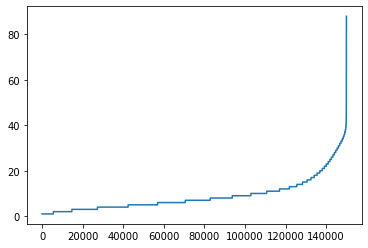

142587


In [8]:
import matplotlib.pyplot as plt

sentence_len = [len(sentence) for sentence in sentences]
sentence_len.sort()

plt.plot(sentence_len)
plt.show()

print(sum([int(i <= 25) for i in sentence_len]))

* 단어의 앞에서부터 5글자로 자르기

In [9]:
sentences_new = []

for sentence in sentences:
    sentences_new.append([word[:5] for word in sentence][:25])

sentences = sentences_new

for i in range(5):
    print(sentences[i])

['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조', '가볍지', '않구나']
['너무재밓었']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨', '늙어보이기', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


# III. 'tokenizer( )' and 'pad_sequences( )'

> ## 1) '20000'개 단어 사용

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = 20000)
tokenizer.fit_on_texts(sentences)
train_X = tokenizer.texts_to_sequences(sentences)

train_X = pad_sequences(train_X, padding = 'post')

print(train_X[:5])

[[   25   884     8  5795  1111     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [  588  5796  6697     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [   71   346    31    35 10468     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [  106  5338     4     2  2169   869   573     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]]


> ## 2) tokenizer( ) 동작 확인

* 존재하는 단어 매핑
 - '경우는', '연기가'

In [11]:
print(tokenizer.index_word[19999])
print(tokenizer.index_word[20000])

temp = tokenizer.texts_to_sequences(['#$#$#', '경우는', '잊혀질', '연기가'])
print(temp)

temp = pad_sequences(temp, padding = 'post')
print(temp) 

경우는
잊혀질
[[], [19999], [], [106]]
[[    0]
 [19999]
 [    0]
 [  106]]


# IV. Modeling

> ## 1) Model Structure

In [12]:
from keras import models, layers

model = models.Sequential()

model.add(layers.Embedding(20000, 300, input_length = 25))

model.add(layers.LSTM(32))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))


model.compile(loss = 'binary_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 300)           6000000   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                42624     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 6,042,657
Trainable params: 6,042,657
Non-trainable params: 0
_________________________________________________________________


> ## 2) Model Fit

* 약 10분

In [13]:
%%time

history = model.fit(train_X, train_Y, 
                    epochs = 10, 
                    batch_size = 128, 
                    validation_split = 0.2)

Epoch 1/10
938/938 [==============================] - 88s 61ms/step - loss: 0.5301 - accuracy: 0.6989 - val_loss: 0.3763 - val_accuracy: 0.8238
Epoch 2/10
938/938 [==============================] - 56s 59ms/step - loss: 0.3186 - accuracy: 0.8534 - val_loss: 0.3848 - val_accuracy: 0.8136
Epoch 3/10
938/938 [==============================] - 56s 59ms/step - loss: 0.2647 - accuracy: 0.8760 - val_loss: 0.4184 - val_accuracy: 0.8176
Epoch 4/10
938/938 [==============================] - 56s 59ms/step - loss: 0.2232 - accuracy: 0.8929 - val_loss: 0.4668 - val_accuracy: 0.8111
Epoch 5/10
938/938 [==============================] - 56s 59ms/step - loss: 0.1838 - accuracy: 0.9123 - val_loss: 0.5399 - val_accuracy: 0.8065
Epoch 6/10
938/938 [==============================] - 56s 59ms/step - loss: 0.1592 - accuracy: 0.9231 - val_loss: 0.6244 - val_accuracy: 0.8048
Epoch 7/10
938/938 [==============================] - 56s 60ms/step - loss: 0.1403 - accuracy: 0.9306 - val_loss: 0.6580 - val_accuracy:

# V. Validation

> ## 1) Visualization

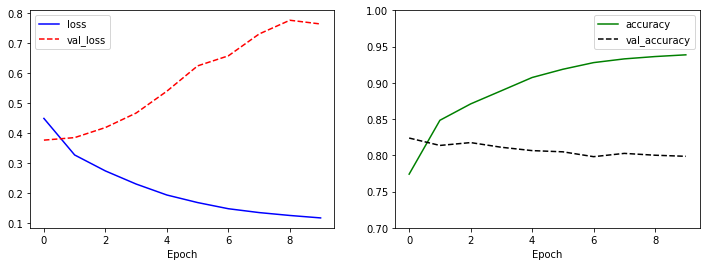

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label = 'loss')
plt.plot(history.history['val_loss'], 'r--', label = 'val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label = 'accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

> ## 2) [Loss, Accuracy]

In [15]:
test_text_X = [row.split('\t')[1] for row in test_text.split('\n')[1:] if row.count('\t') > 0]
test_text_X = [clean_str(sentence) for sentence in test_text_X]

sentences = [sentence.split(' ') for sentence in test_text_X]

sentences_new = []

for sentence in sentences:
    sentences_new.append([word[:5] for word in sentence][:25])
sentences = sentences_new

test_X = tokenizer.texts_to_sequences(sentences)
test_X = pad_sequences(test_X, padding = 'post')

model.evaluate(test_X, test_Y, verbose = 0)

[0.7897635698318481, 0.7891600131988525]

# VI. 문장 감성 분석

* 입력 단어에 따라서 감성 분석 결과 변화
 - 긍정('1') -> 부정('0')

In [16]:
test_sentence = '재미있을 줄 알았는데 완전 실망했다. 너무 졸리고 돈이 아까웠다.'
test_sentence = test_sentence.split(' ')

test_sentences = []
now_sentence = []

for word in test_sentence:
    now_sentence.append(word)
    test_sentences.append(now_sentence[:])
    
test_X_1 = tokenizer.texts_to_sequences(test_sentences)
test_X_1 = pad_sequences(test_X_1, padding = 'post', maxlen = 25)

prediction = model.predict(test_X_1)

for idx, sentence in enumerate(test_sentences):
    print(sentence)
    print(prediction[idx])

['재미있을']
[0.34328267]
['재미있을', '줄']
[0.9316357]
['재미있을', '줄', '알았는데']
[0.9665004]
['재미있을', '줄', '알았는데', '완전']
[0.50702566]
['재미있을', '줄', '알았는데', '완전', '실망했다.']
[0.50702566]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무']
[0.05992611]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고']
[0.00067344]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고', '돈이']
[0.00031857]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고', '돈이', '아까웠다.']
[0.00031857]
